# Deep Learning Fundamentals
# Assignment 2: CNNs for Image Classification

## 1 Import Libraries and Files

100%|██████████| 170M/170M [00:02<00:00, 59.0MB/s]


Extracting /Users/biancatan/Documents/Masters of AI & ML/Trimester 4/Deep Learning Fundamentals/Assignment 2/cifar-10/cifar-10-python.tar.gz to /Users/biancatan/Documents/Masters of AI & ML/Trimester 4/Deep Learning Fundamentals/Assignment 2/cifar-10
Files already downloaded and verified


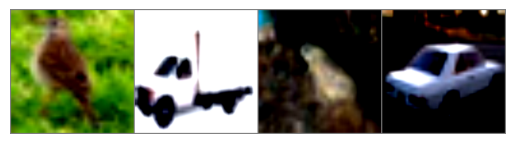

 bird truck  frog   car
Training dataset (reduced) size: 8000
Validation dataset (reduced) size: 2000
Test dataset (reduced) size: 2000


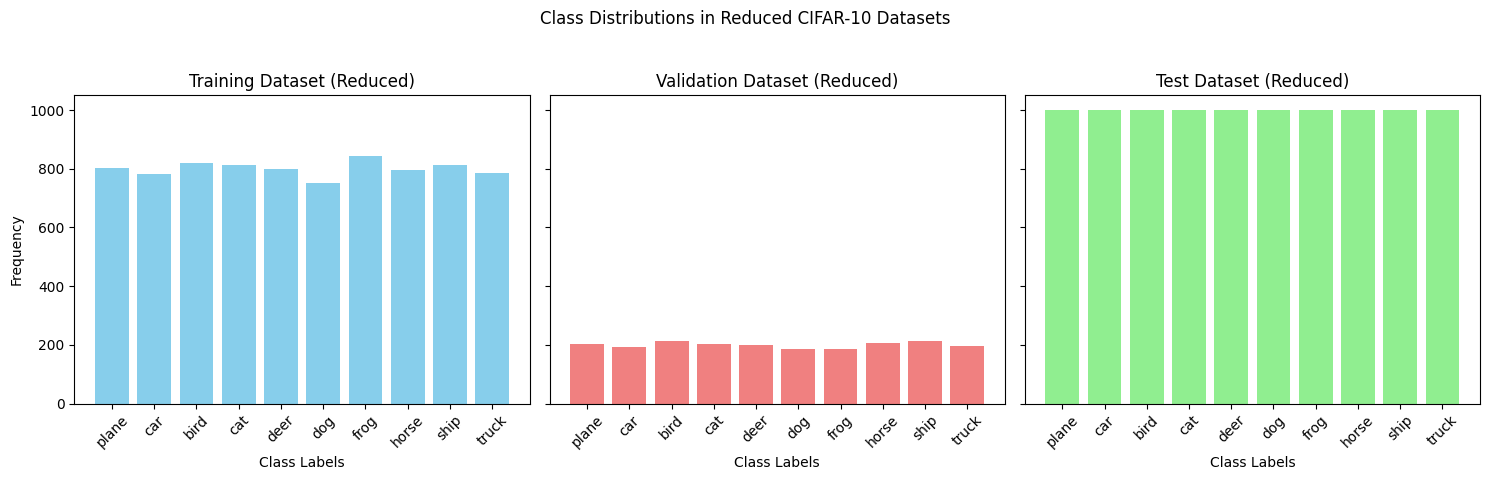

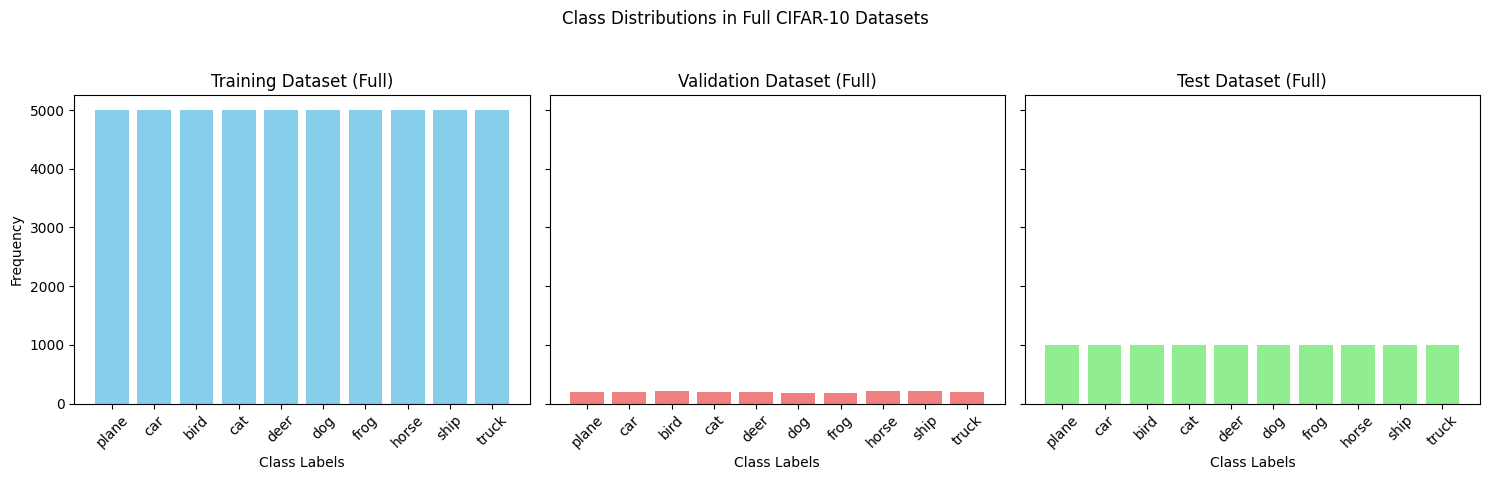

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from collections import Counter
from sklearn.model_selection import train_test_split  # For stratified sampling
import time

# Path to your CIFAR-10 dataset
data_path = '/Users/biancatan/Documents/Masters of AI & ML/Trimester 4/Deep Learning Fundamentals/Assignment 2/cifar-10'

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit the input size of models
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.482 2, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 Data (Full dataset)
train_set = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

# Define class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Calculate the class distribution in the original dataset
train_labels = np.array(train_set.targets)
test_labels = np.array(test_set.targets)

# Define the fraction of data you want to retain for hyperparameter tuning (e.g., 20%)
fraction = 0.2

# Stratified Sampling to reduce the dataset size for hyperparameter tuning
train_indices, _ = train_test_split(np.arange(len(train_set)), test_size=1 - fraction, stratify=train_labels)
test_indices, _ = train_test_split(np.arange(len(test_set)), test_size=1 - fraction, stratify=test_labels)

# Create reduced datasets using the stratified indices (for hyperparameter tuning)
train_subset = Subset(train_set, train_indices)
test_subset = Subset(test_set, test_indices)

# Split train subset further into training and validation subsets (for hyperparameter tuning)
val_size = int(0.2 * len(train_subset))  # 20% of the reduced training set for validation
train_size = len(train_subset) - val_size
train_dataset, val_dataset = random_split(train_subset, [train_size, val_size])

# Create DataLoaders for the reduced datasets (used for hyperparameter tuning)
train_loader_reduced = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_reduced = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_reduced = DataLoader(test_subset, batch_size=64, shuffle=False)

# Create DataLoaders for the full datasets (used for final model training, validation, and testing)
train_loader_full = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader_full = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_full = DataLoader(test_set, batch_size=64, shuffle=False)

# Function to unnormalize and show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis
    plt.show()

# Get a batch of random training images from the reduced dataset (for hyperparameter tuning)
dataiter = iter(train_loader_reduced)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Print the sizes of each dataset (reduced datasets for hyperparameter tuning)
print("Training dataset (reduced) size:", len(train_dataset))
print("Validation dataset (reduced) size:", len(val_dataset))
print("Test dataset (reduced) size:", len(test_subset))

# Helper function to plot class distributions side by side
def plot_class_distributions_side_by_side(train_counts, val_counts, test_counts, dataset_type='Reduced'):
    labels = list(range(10))  # CIFAR-10 class indices
    class_names = classes  # Defined earlier with CIFAR-10 labels

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # Plot Training Data Distribution
    axs[0].bar(labels, [train_counts[i] for i in labels], color='skyblue')
    axs[0].set_title(f"Training Dataset ({dataset_type})")
    axs[0].set_xlabel("Class Labels")
    axs[0].set_ylabel("Frequency")
    axs[0].set_xticks(labels)
    axs[0].set_xticklabels(class_names, rotation=45)

    # Plot Validation Data Distribution
    axs[1].bar(labels, [val_counts[i] for i in labels], color='lightcoral')
    axs[1].set_title(f"Validation Dataset ({dataset_type})")
    axs[1].set_xlabel("Class Labels")
    axs[1].set_xticks(labels)
    axs[1].set_xticklabels(class_names, rotation=45)

    # Plot Test Data Distribution
    axs[2].bar(labels, [test_counts[i] for i in labels], color='lightgreen')
    axs[2].set_title(f"Test Dataset ({dataset_type})")
    axs[2].set_xlabel("Class Labels")
    axs[2].set_xticks(labels)
    axs[2].set_xticklabels(class_names, rotation=45)

    plt.suptitle(f"Class Distributions in {dataset_type} CIFAR-10 Datasets")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Get the class distribution of the datasets (for hyperparameter tuning)
train_counts_reduced = Counter([train_set.targets[i] for i in train_dataset.indices])
val_counts_reduced = Counter([train_set.targets[i] for i in val_dataset.indices])
test_counts_reduced = Counter(test_set.targets)

# Call the function to plot for the reduced dataset
plot_class_distributions_side_by_side(train_counts_reduced, val_counts_reduced, test_counts_reduced, dataset_type="Reduced")

# For final model training and evaluation, use the full dataset
# Optionally, plot distributions for the full datasets
train_counts_full = Counter(train_set.targets)
val_counts_full = Counter([train_set.targets[i] for i in val_dataset.indices])  # Same validation set
test_counts_full = Counter(test_set.targets)

# Call the function to plot for the full dataset
plot_class_distributions_side_by_side(train_counts_full, val_counts_full, test_counts_full, dataset_type="Full")


In the plots above, it can be seen that even after reduction of the training and validation dataset, the class distribution is well balance hense it does not require any rebalancing.

## 2 Model Training and Validation

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time

In [5]:
# Function to train and validate model
# Hyper-parameter Tuning
def train_validate(model_name, train_loader, val_loader, num_classes=10, pretrained=False, num_epochs=30, use_weight_decay=False):
    # Hyperparameters
    learning_rates = [0.1, 0.01, 0.001]  # List of learning rates to try
    optimizers = {
        'SGD': optim.SGD,
        'Adam': optim.Adam,
        'RMSprop': optim.RMSprop
    }
    weight_decay = 5e-4 if use_weight_decay else 0.0  # Use weight decay if specified

    # Model selection
    print(f"Initializing model: {model_name} with {'pretrained' if pretrained else 'random'} weights.")
    if model_name == 'resnet18':
        model = models.resnet18(weights=None if not pretrained else "IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'alexnet':
        model = models.alexnet(weights=None if not pretrained else "IMAGENET1K_V1")
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=None if not pretrained else "IMAGENET1K_V1")
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Check if CUDA is available; if not, default to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    # Create a DataFrame to store results
    columns = ['learning_rate', 'optimizer', 'weight_decay', 'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc']
    results_df = pd.DataFrame(columns=columns)

    # Track total time taken
    total_time_start = time.time()

    # Loop through learning rates and optimizers
    for lr in learning_rates:
        for optimizer_name, optimizer_class in optimizers.items():
            print(f"\nTraining with Learning Rate: {lr}, Optimizer: {optimizer_name}, Weight Decay: {'Yes' if use_weight_decay else 'No'}")

            # Set up optimizer
            optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)
            criterion = nn.CrossEntropyLoss()

            for epoch in range(num_epochs):
                print(f"\nEpoch {epoch + 1}/{num_epochs}")

                # Training phase
                model.train()
                running_loss, running_corrects = 0.0, 0
                print("Training...")
                for i, (images, labels) in enumerate(train_loader):
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    _, preds = torch.max(outputs, 1)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = running_corrects.double() / len(train_loader.dataset)
                print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

                # Validation phase
                print("Validating...")
                model.eval()
                val_running_loss, val_running_corrects = 0.0, 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        val_running_loss += loss.item() * images.size(0)
                        _, preds = torch.max(outputs, 1)
                        val_running_corrects += torch.sum(preds == labels.data)

                val_epoch_loss = val_running_loss / len(val_loader.dataset)
                val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
                print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

                # Store results in DataFrame using pd.concat
                result_row = pd.DataFrame([{
                    'learning_rate': lr,
                    'optimizer': optimizer_name,
                    'weight_decay': use_weight_decay,
                    'epoch': epoch + 1,
                    'train_loss': epoch_loss,
                    'train_acc': epoch_acc.item(),
                    'val_loss': val_epoch_loss,
                    'val_acc': val_epoch_acc.item()
                }])
                results_df = pd.concat([results_df, result_row], ignore_index=True)

    # Final training time
    total_time_end = time.time()
    # Convert the total time from seconds to minutes and print it
    total_time_minutes = (total_time_end - total_time_start) / 60
    print(f"Total training time: {total_time_minutes:.2f} minutes")

    # Return final model and results
    return model, results_df


## 2.1 Hyper-parameter Tuning

Here I will be doing hyper-parameter tuning, experimenting with the following parameters:
- Learning Rate: 0.1, 0.01, 0.001
- Optimizer: SGD, Adam, RMSprop

The weights will be set to 0 as we aim to train the model from scratch. I chose to use a reduced dataset for the tuning due to computational constraints. The total epochs to train and validate the model is set to 30 to balance between having sufficient epochs and computational efficiency. This will allow me to understand how the model generalizes over the epochs.

### 2.1.1 Model: ResNet-18

In [6]:
# Train and validate the model
model_name = 'resnet18'
model_resnet18, results_df_resnet18 = train_validate(model_name, train_loader_reduced, val_loader_reduced)

# Display results
print("Training Results:\n", results_df_resnet18.head())

Initializing model: resnet18 with random weights.
Using device: cuda

Training with Learning Rate: 0.1, Optimizer: SGD, Weight Decay: No

Epoch 1/30
Training...
Loss: 2.2256, Accuracy: 0.2384
Validating...
Validation Loss: 1.7171, Accuracy: 0.3450

Epoch 2/30
Training...


<ipython-input-5-e04f5b086fb2>:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)


Loss: 1.7254, Accuracy: 0.3409
Validating...
Validation Loss: 1.8251, Accuracy: 0.3250

Epoch 3/30
Training...
Loss: 1.5636, Accuracy: 0.4168
Validating...
Validation Loss: 1.5581, Accuracy: 0.4220

Epoch 4/30
Training...
Loss: 1.4300, Accuracy: 0.4642
Validating...
Validation Loss: 2.1699, Accuracy: 0.4205

Epoch 5/30
Training...
Loss: 1.3383, Accuracy: 0.5044
Validating...
Validation Loss: 1.4252, Accuracy: 0.4755

Epoch 6/30
Training...
Loss: 1.2149, Accuracy: 0.5523
Validating...
Validation Loss: 1.6030, Accuracy: 0.4625

Epoch 7/30
Training...
Loss: 1.1100, Accuracy: 0.5974
Validating...
Validation Loss: 1.1710, Accuracy: 0.5775

Epoch 8/30
Training...
Loss: 1.0246, Accuracy: 0.6271
Validating...
Validation Loss: 1.1886, Accuracy: 0.5780

Epoch 9/30
Training...
Loss: 0.9292, Accuracy: 0.6630
Validating...
Validation Loss: 1.3306, Accuracy: 0.5610

Epoch 10/30
Training...
Loss: 0.8103, Accuracy: 0.7103
Validating...
Validation Loss: 1.6793, Accuracy: 0.5090

Epoch 11/30
Training...

### 2.1.2 Model: AlexNet

In [11]:
# Train and validate the model
model_name = 'alexnet'
model_alexnet, results_df_alexnet = train_validate(model_name, train_loader_reduced, val_loader_reduced)

# Display results
print("Training Results:\n", results_df_alexnet.head())

Initializing model: alexnet with random weights.
Using device: cuda

Training with Learning Rate: 0.1, Optimizer: SGD, Weight Decay: No

Epoch 1/30
Training...
Loss: 2.2760, Accuracy: 0.1343
Validating...
Validation Loss: 2.2767, Accuracy: 0.1730

Epoch 2/30
Training...


<ipython-input-5-e04f5b086fb2>:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)


Loss: 2.1638, Accuracy: 0.1965
Validating...
Validation Loss: 2.1097, Accuracy: 0.2410

Epoch 3/30
Training...
Loss: 2.0269, Accuracy: 0.2500
Validating...
Validation Loss: 1.9286, Accuracy: 0.3040

Epoch 4/30
Training...
Loss: 1.9218, Accuracy: 0.2931
Validating...
Validation Loss: 2.0209, Accuracy: 0.2690

Epoch 5/30
Training...
Loss: 1.7774, Accuracy: 0.3496
Validating...
Validation Loss: 1.6143, Accuracy: 0.4070

Epoch 6/30
Training...
Loss: 1.6799, Accuracy: 0.3864
Validating...
Validation Loss: 1.5884, Accuracy: 0.4155

Epoch 7/30
Training...
Loss: 1.5907, Accuracy: 0.4203
Validating...
Validation Loss: 1.5087, Accuracy: 0.4495

Epoch 8/30
Training...
Loss: 1.4814, Accuracy: 0.4549
Validating...
Validation Loss: 1.4560, Accuracy: 0.4670

Epoch 9/30
Training...
Loss: 1.4422, Accuracy: 0.4748
Validating...
Validation Loss: 1.3387, Accuracy: 0.5160

Epoch 10/30
Training...
Loss: 1.3333, Accuracy: 0.5156
Validating...
Validation Loss: 1.3457, Accuracy: 0.5280

Epoch 11/30
Training...

### 2.1.3 Model: MobileNetV2

In [12]:
# Train and validate the model
model_name = 'mobilenet_v2'
model_mobilenet_v2, results_df_mobilenet_v2 = train_validate(model_name, train_loader_reduced, val_loader_reduced)

# Display results
print("Training Results:\n", results_df_mobilenet_v2.head())

Initializing model: mobilenet_v2 with random weights.
Using device: cuda

Training with Learning Rate: 0.1, Optimizer: SGD, Weight Decay: No

Epoch 1/30
Training...
Loss: 2.2952, Accuracy: 0.2296
Validating...
Validation Loss: 2.3865, Accuracy: 0.2780

Epoch 2/30
Training...


<ipython-input-5-e04f5b086fb2>:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)


Loss: 1.7588, Accuracy: 0.3549
Validating...
Validation Loss: 1.8419, Accuracy: 0.3670

Epoch 3/30
Training...
Loss: 1.5783, Accuracy: 0.4216
Validating...
Validation Loss: 1.5467, Accuracy: 0.4440

Epoch 4/30
Training...
Loss: 1.4124, Accuracy: 0.4751
Validating...
Validation Loss: 1.3561, Accuracy: 0.5010

Epoch 5/30
Training...
Loss: 1.3050, Accuracy: 0.5319
Validating...
Validation Loss: 1.3113, Accuracy: 0.5315

Epoch 6/30
Training...
Loss: 1.1879, Accuracy: 0.5700
Validating...
Validation Loss: 1.6594, Accuracy: 0.4360

Epoch 7/30
Training...
Loss: 1.0721, Accuracy: 0.6131
Validating...
Validation Loss: 1.1339, Accuracy: 0.5955

Epoch 8/30
Training...
Loss: 0.9854, Accuracy: 0.6482
Validating...
Validation Loss: 1.1709, Accuracy: 0.5955

Epoch 9/30
Training...
Loss: 0.8944, Accuracy: 0.6863
Validating...
Validation Loss: 0.9768, Accuracy: 0.6560

Epoch 10/30
Training...
Loss: 0.8344, Accuracy: 0.7030
Validating...
Validation Loss: 1.1274, Accuracy: 0.6220

Epoch 11/30
Training...

### Visualizations of the Traing and Validation Epochs

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_training_validation_metrics(results_df):
    # Set styles for different optimizers and learning rates
    color_palette = sns.color_palette("husl", n_colors=results_df['optimizer'].nunique())  # Distinct colors for each optimizer
    line_styles = ['-', '--', '-.', ':']  # Line patterns for different learning rates

    # Create mappings for colors and line styles
    optimizer_colors = {opt: color for opt, color in zip(results_df['optimizer'].unique(), color_palette)}
    lr_line_styles = {lr: style for lr, style in zip(sorted(results_df['learning_rate'].unique()), line_styles)}

    # Initialize subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()  # Flatten for easy iteration

    # Titles for subplots
    plot_titles = ['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy']
    metrics = ['train_loss', 'train_acc', 'val_loss', 'val_acc']  # Corresponding metrics

    for idx, (metric, title) in enumerate(zip(metrics, plot_titles)):
        ax = axs[idx]
        ax.set_title(title)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.split('_')[1].capitalize())

        # Plot each combination of optimizer and learning rate
        for (optimizer, lr), group in results_df.groupby(['optimizer', 'learning_rate']):
            color = optimizer_colors[optimizer]
            linestyle = lr_line_styles[lr]
            ax.plot(
                group['epoch'], group[metric],
                label=f"{optimizer} (lr={lr})",
                color=color, linestyle=linestyle
            )

        ax.legend(loc="best")

    plt.tight_layout()
    plt.show()


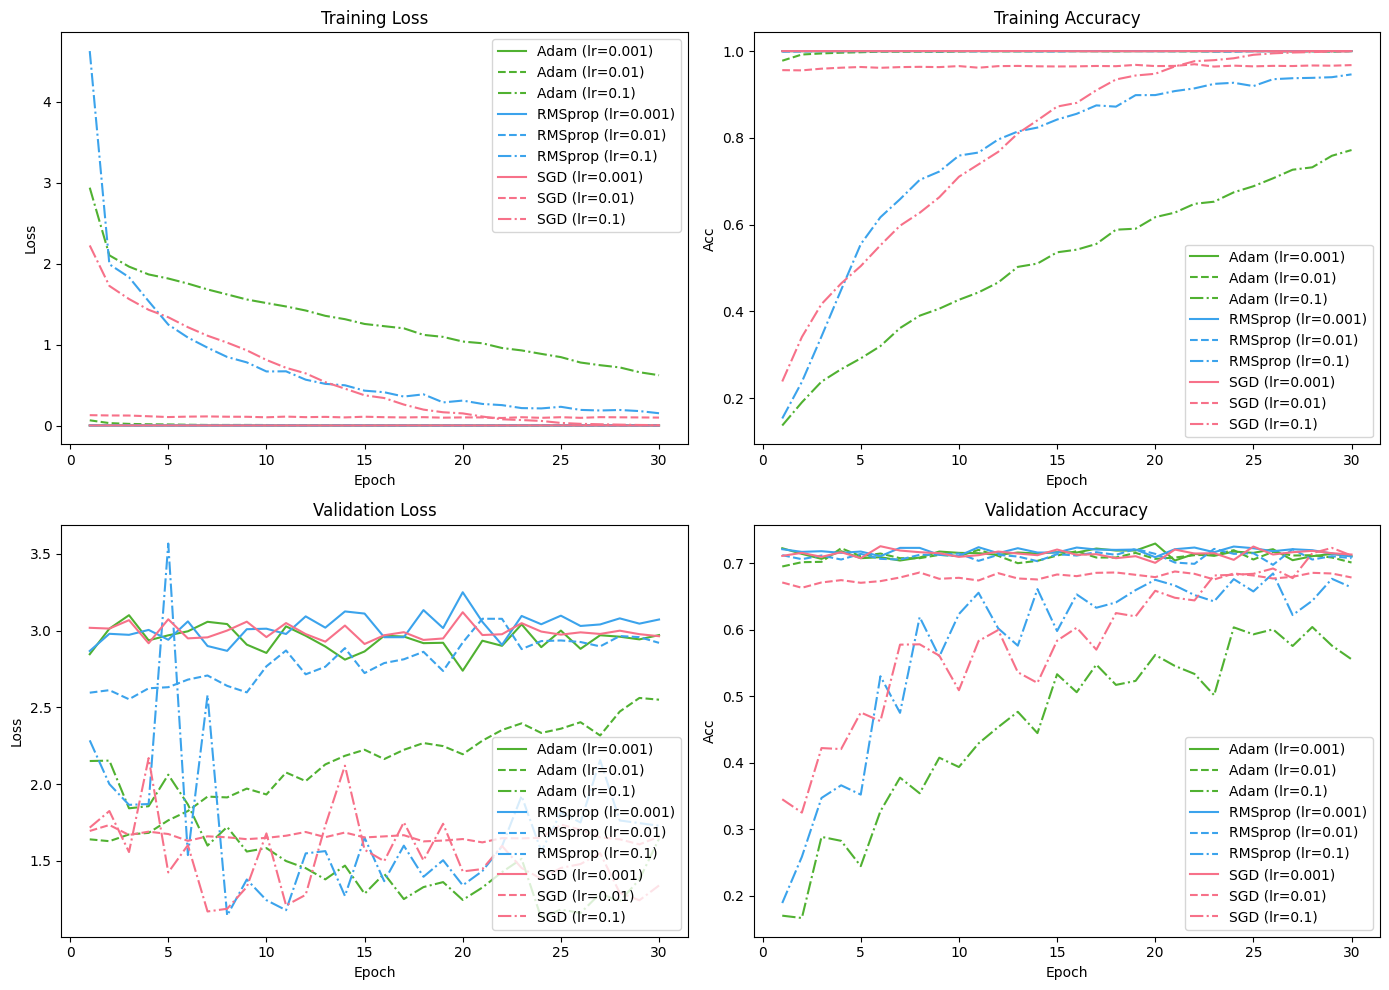

In [10]:
plot_training_validation_metrics(results_df_resnet18)

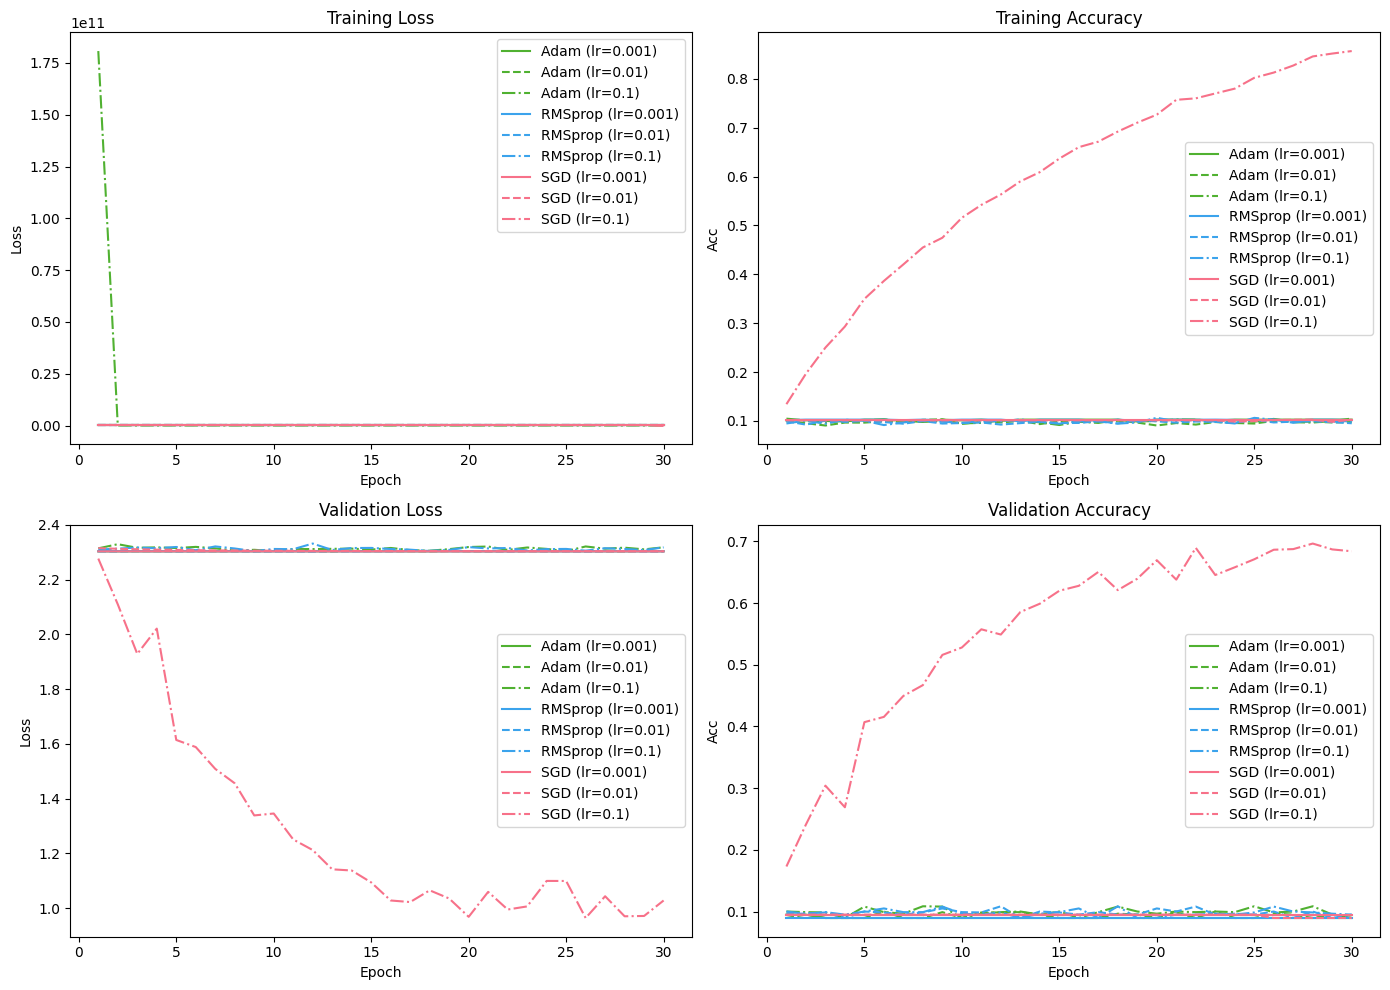

In [13]:
plot_training_validation_metrics(results_df_alexnet)

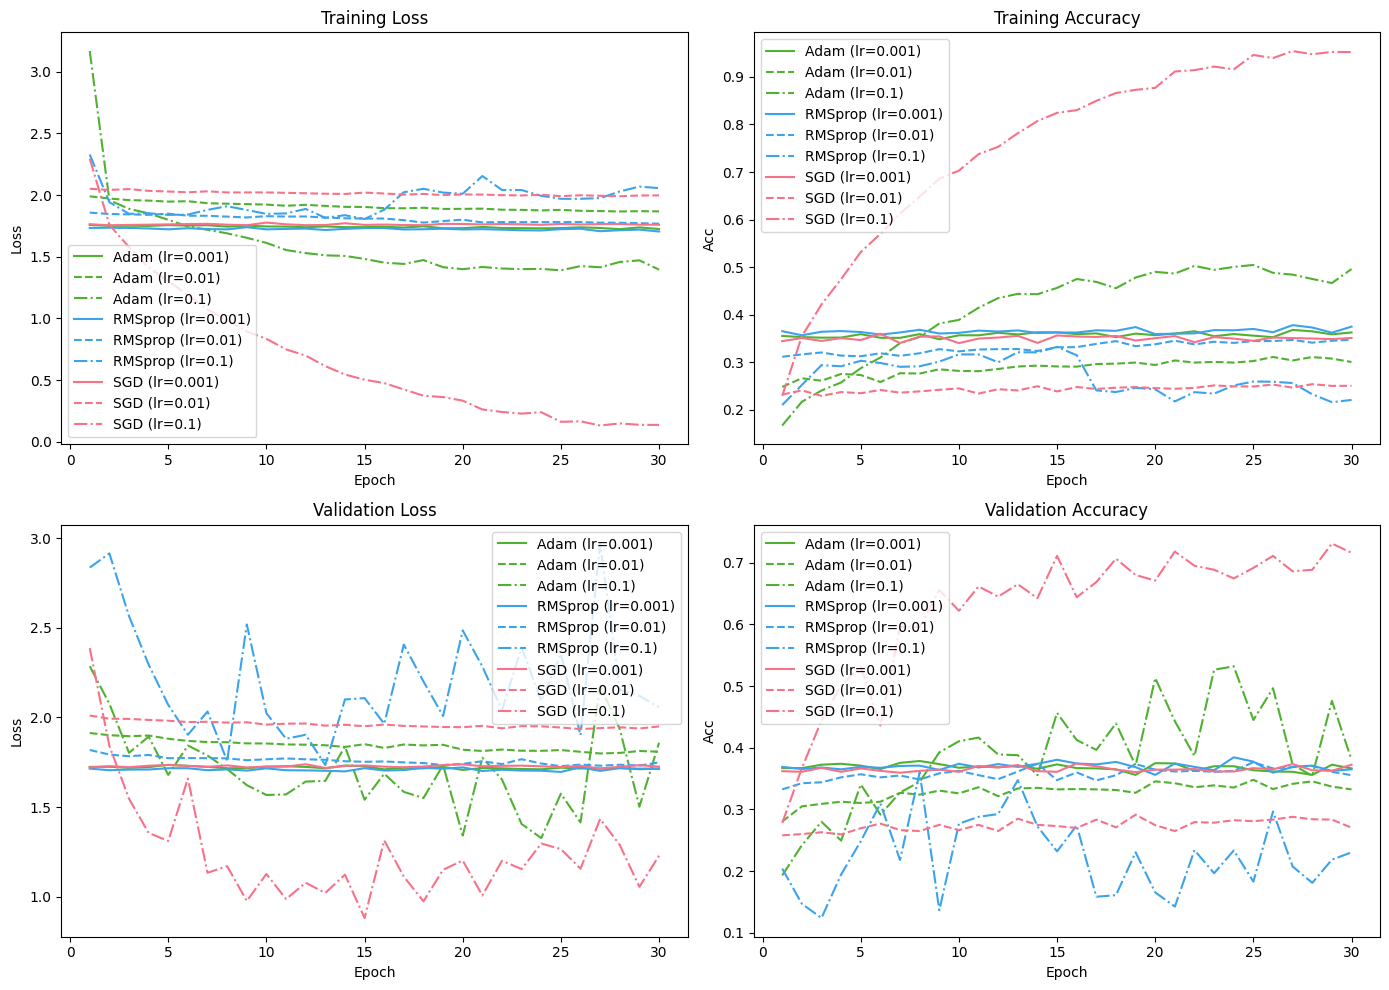

In [14]:
plot_training_validation_metrics(results_df_mobilenet_v2)

**Save results to csv file as re-running model is computationally expensive** [May require results for analysis]

In [15]:
# Save DataFrame to a CSV file
results_df_resnet18.to_csv('results_df_resnet18.csv', index=False)  # index=False prevents writing row indices to the file

In [16]:
# Save DataFrame to a CSV file
results_df_alexnet.to_csv('results_df_alexnet.csv', index=False)  # index=False prevents writing row indices to the file

In [17]:
# Save DataFrame to a CSV file
results_df_mobilenet_v2.to_csv('results_df_mobilenet_v2.csv', index=False)  # index=False prevents writing row indices to the file

## 3 Final Model
The best model was chosen to be ResNet-18 with learning rate of 0.001 and optimizer RMSprop. The model produced the most stable generalisation with the highest validation accuracy. Below I trained the model with the full dataset and 50 epochs. Next, I test the model with the full testing dataset and obtained the test accuracy.

In [18]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models

# Function to train and validate with a fixed model and parameter setup
def train_final(model_name, train_loader, val_loader, num_classes=10, pretrained=False,
                num_epochs=50, optimizer_name='Adam', learning_rate=0.001, use_weight_decay=False):
    # Hyperparameters
    weight_decay = 5e-4 if use_weight_decay else 0.0  # Use weight decay if specified

    # Model selection
    print(f"Initializing model: {model_name} with {'pretrained' if pretrained else 'random'} weights.")
    if model_name == 'resnet18':
        model = models.resnet18(weights=None if not pretrained else "IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'alexnet':
        model = models.alexnet(weights=None if not pretrained else "IMAGENET1K_V1")
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=None if not pretrained else "IMAGENET1K_V1")
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Check if CUDA is available; if not, default to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    # Create a DataFrame to store results
    columns = ['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc']
    results_df = pd.DataFrame(columns=columns)

    # Track total time taken
    total_time_start = time.time()

    # Set up the chosen optimizer
    optimizers = {
        'SGD': optim.SGD,
        'Adam': optim.Adam,
        'RMSprop': optim.RMSprop
    }

    if optimizer_name not in optimizers:
        raise ValueError(f"Optimizer {optimizer_name} not recognized. Choose from 'SGD', 'Adam', or 'RMSprop'.")

    optimizer = optimizers[optimizer_name](model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        print("Training...")
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation phase
        print("Validating...")
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

        # Store results in DataFrame
        result_row = pd.DataFrame([{
            'epoch': epoch + 1,
            'train_loss': epoch_loss,
            'train_acc': epoch_acc.item(),
            'val_loss': val_epoch_loss,
            'val_acc': val_epoch_acc.item()
        }])
        results_df = pd.concat([results_df, result_row], ignore_index=True)

    # Final training time
    total_time_end = time.time()
    total_time_minutes = (total_time_end - total_time_start) / 60
    print(f"Total training time: {total_time_minutes:.2f} minutes")

    # Return final model and results
    return model, results_df


In [19]:
# Final Chosen Model
model_name = 'resnet18'
train_loader = train_loader_full 
val_loader = val_loader_full  
num_classes = 10  
num_epochs = 50  
optimizer_name = 'RMSprop'  # Choose from 'SGD', 'Adam', or 'RMSprop'
learning_rate = 0.001  # Choose optimal learning rate
use_weight_decay = False  # Set True for weight decay, but we do not want to use pretrain weights for this assignment 

# Train and validate the model with these fixed parameters
final_model, results_df = train_final(model_name, train_loader, val_loader,
                                      num_classes=num_classes,
                                      num_epochs=num_epochs,
                                      optimizer_name=optimizer_name,
                                      learning_rate=learning_rate,
                                      use_weight_decay=use_weight_decay)

# Print the results DataFrame
print(results_df)

Initializing model: resnet18 with random weights.
Using device: cuda

Epoch 1/50
Training...
Loss: 1.5350, Accuracy: 0.4354
Validating...
Validation Loss: 1.4806, Accuracy: 0.4915

Epoch 2/50
Training...


<ipython-input-18-4fdd7e02e955>:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)


Loss: 0.9061, Accuracy: 0.6784
Validating...
Validation Loss: 1.0542, Accuracy: 0.6320

Epoch 3/50
Training...
Loss: 0.6635, Accuracy: 0.7679
Validating...
Validation Loss: 1.3430, Accuracy: 0.5650

Epoch 4/50
Training...
Loss: 0.5393, Accuracy: 0.8115
Validating...
Validation Loss: 0.8639, Accuracy: 0.7020

Epoch 5/50
Training...
Loss: 0.4498, Accuracy: 0.8418
Validating...
Validation Loss: 0.4811, Accuracy: 0.8345

Epoch 6/50
Training...
Loss: 0.3820, Accuracy: 0.8683
Validating...
Validation Loss: 0.4439, Accuracy: 0.8445

Epoch 7/50
Training...
Loss: 0.3224, Accuracy: 0.8873
Validating...
Validation Loss: 0.5857, Accuracy: 0.8180

Epoch 8/50
Training...
Loss: 0.2693, Accuracy: 0.9046
Validating...
Validation Loss: 0.3063, Accuracy: 0.8875

Epoch 9/50
Training...
Loss: 0.2289, Accuracy: 0.9197
Validating...
Validation Loss: 0.6464, Accuracy: 0.8280

Epoch 10/50
Training...
Loss: 0.1879, Accuracy: 0.9345
Validating...
Validation Loss: 0.1569, Accuracy: 0.9520

Epoch 11/50
Training...

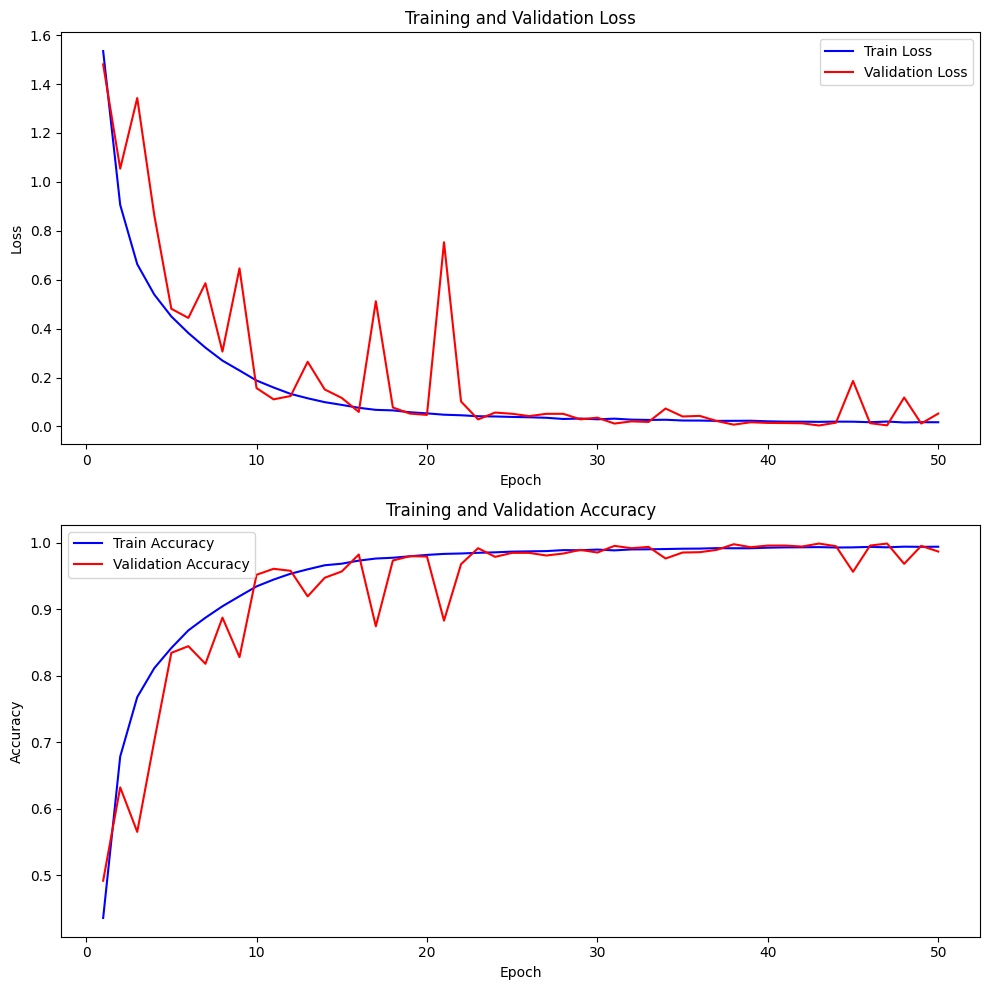

In [21]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Train and Validation Loss
axs[0].plot(results_df['epoch'], results_df['train_loss'], label='Train Loss', color='blue')
axs[0].plot(results_df['epoch'], results_df['val_loss'], label='Validation Loss', color='red')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Train and Validation Accuracy
axs[1].plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy', color='blue')
axs[1].plot(results_df['epoch'], results_df['val_acc'], label='Validation Accuracy', color='red')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [22]:
# Save DataFrame to a CSV file
results_df.to_csv('results_df.csv', index=False)  # index=False prevents writing row indices to the file

In [26]:
import torch
import torch.nn as nn

# Function to test the model
def test_model(model, test_loader, criterion):
    # Check if CUDA is available; if not, default to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to the correct device

    # Ensure the model is in evaluation mode
    model.eval()

    running_loss, running_corrects = 0.0, 0

    # Disable gradient calculation for testing phase
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Send to device
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc


In [28]:
# Test the model after training
test_loss, test_acc = test_model(final_model, test_loader_full, nn.CrossEntropyLoss())

# Optionally, you can store the results in a DataFrame
test_results_df = pd.DataFrame([{
    'test_loss': test_loss,
    'test_acc': test_acc.item()
}])

# Print or save results as needed
print(test_results_df)

# Test Loss: 0.8059, Test Accuracy: 0.8673

Test Loss: 0.8059, Test Accuracy: 0.8673
   test_loss  test_acc
0    0.80587    0.8673


Therefore, the final model obtained an accuracy of 86.7%.